In [11]:
from env import ShogiEnv
import gymnasium as gym

import pandas as pd
import torch
from model.shogi_agent import ShogiAgent
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [12]:
gym.register(id="Shogi-v0", entry_point="env:ShogiEnv", kwargs={})
env: ShogiEnv = gym.make("Shogi-v0")

In [13]:
import time


def save_load_model(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Executed {func.__name__} in {execution_time:.4f} seconds")
        return result

    return wrapper

## Train the Agent

In [14]:
@save_load_model
def play_game(player: ShogiAgent):
    loss = []
    steps = 0
    score = 0
    terminated = False
    truncated = False

    env.reset()

    # until game is not finished
    while not terminated and not truncated:
        steps += 1

        # choose action, here the agent choose whether to explore or exploit
        action_index, move, current_bit_state, valid_moves_tensor = (
            player.select_action(env)
        )
        valid_moves = torch.from_numpy(valid_moves_tensor.flatten())

        next_bit_state, reward, terminated, truncated, _ = env.step(move)
        score += reward

        print(f"Move: {env.move}. Total reward: {score}")

        mask, _ = env.mask_and_valid_moves()
        mask_tensor = torch.from_numpy(mask.flatten())

        # store sample in memory
        player.remember(
            player.MAX_PRIORITY,
            current_bit_state,
            action_index,
            reward,
            next_bit_state[0],
            (terminated or truncated),
            valid_moves,
            mask_tensor,
        )

        # train model and store loss
        loss.append(player.learn_experience_replay(debug=False))

        # adjust epsilon (exploration rate)
        player.adaptive_e_greedy()

    return score, steps, loss

In [15]:
def Q_learning(agent: ShogiAgent, games_to_play: int):

    loss = []
    final_score = []
    games = 0
    steps = 0

    # we play n games
    while games < games_to_play:
        print(f"Game {games} of {games_to_play}")
        games += 1
        score, game_steps, game_loss = play_game(agent)
        loss += game_loss
        steps += game_steps
        final_score.append(score)

    # plot training results
    score_df = pd.DataFrame(final_score, columns=["score"])
    score_df["ma"] = score_df["score"].rolling(window=games // 5).mean()
    loss_df = pd.DataFrame(loss, columns=["loss"])
    loss_df["ma"] = loss_df["loss"].rolling(window=steps // 5).mean()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the score chart in the first subplot
    ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
    ax1.plot(score_df.index, score_df["ma"])
    ax1.set_title("Final score by game")

    # Plot the loss chart in the second subplot
    ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
    ax2.plot(loss_df.index, loss_df["ma"])
    ax2.set_title("Loss by training step")

    # Show the plot
    plt.show()

Game 0 of 10
Move: 1. Total reward: 0.0
Move: 2. Total reward: 0.0
Move: 3. Total reward: 0.0
Move: 4. Total reward: 0.0
Move: 5. Total reward: 0.0
Move: 6. Total reward: 0.0
Move: 7. Total reward: 0.0
Move: 8. Total reward: 0.0
Move: 9. Total reward: 0.0
Move: 10. Total reward: 0.0
Move: 11. Total reward: 0.0
Move: 12. Total reward: 0.0
Move: 13. Total reward: 0.0
Move: 14. Total reward: 0.0
Move: 15. Total reward: 0.0
Move: 16. Total reward: 0.0
Move: 17. Total reward: 0.0
Move: 18. Total reward: 0.0
Move: 19. Total reward: 0.0
Move: 20. Total reward: 0.0
Move: 21. Total reward: 0.0
Move: 22. Total reward: 0.0
Move: 23. Total reward: 0.0
Move: 24. Total reward: 0.0
Move: 25. Total reward: 0.0
Move: 26. Total reward: 0.0
Move: 27. Total reward: 0.0
Move: 28. Total reward: 0.0
Move: 29. Total reward: 0.0
Move: 30. Total reward: 0.0
Move: 31. Total reward: 0.0
Move: 32. Total reward: 0.0
Move: 33. Total reward: 0.0
Move: 34. Total reward: 0.0
Move: 35. Total reward: 0.0
Move: 36. Total 

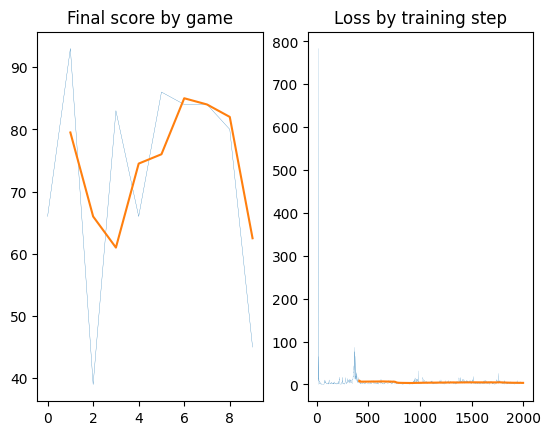

In [16]:
agent = ShogiAgent()
env.reset()

Q_learning(agent, games_to_play=10)

In [17]:
Q_learning(agent, games_to_play=20)

Game 0 of 20
Move: 1. Total reward: 0.0
Move: 2. Total reward: 0.0
Move: 3. Total reward: 0.0
Move: 4. Total reward: 0.0
Move: 5. Total reward: 0.0
Move: 6. Total reward: 0.0
Move: 7. Total reward: 0.0
Move: 8. Total reward: 0.0
Move: 9. Total reward: 0.0
Move: 10. Total reward: 0.0
Move: 11. Total reward: 0.0
Move: 12. Total reward: 0.0
Move: 13. Total reward: 0.0
Move: 14. Total reward: 0.0
Move: 15. Total reward: 0.0
Move: 16. Total reward: 0.0
Move: 17. Total reward: 0.0
Move: 18. Total reward: 0.0
Move: 19. Total reward: 0.0
Move: 20. Total reward: 0.0
Move: 21. Total reward: 0.0
Move: 22. Total reward: 0.0
Move: 23. Total reward: 0.0
Move: 24. Total reward: 1.0
Move: 25. Total reward: 1.0
Move: 26. Total reward: 1.0
Move: 27. Total reward: 1.0
Move: 28. Total reward: 2.0
Move: 29. Total reward: 2.0
Move: 30. Total reward: 8.0
Move: 31. Total reward: 12.0
Move: 32. Total reward: 13.0
Move: 33. Total reward: 13.0
Move: 34. Total reward: 13.0
Move: 35. Total reward: 13.0
Move: 36. T

KeyboardInterrupt: 